In [1]:
import os
import time

from matplotlib import pyplot as plt
from matplotlib_venn import venn3, venn3_circles
import pandas as pd
from tqdm import tqdm_notebook, tnrange
import numpy as np
import pyarrow.parquet as pq
import seaborn as sns
sns.set(style="ticks", color_codes=True)

from utils import read_vcf

%matplotlib inline

In [ ]:
start = time.time()
parquet_file = pq.ParquetFile('/scratch/t.cri.awoodard/indel-filtering/cgp_pindel_filtered_shuffled_hormone_status_full.parquet')
table = parquet_file.read()
full_df = table.to_pandas()
print('read full df in {:.1f} seconds'.format(time.time() - start))

In [2]:
start = time.time()
parquet_file = pq.ParquetFile('/scratch/t.cri.awoodard/indel-filtering/cgp_pindel_filtered_shuffled_hormone_status_slim.parquet')
table = parquet_file.read()
slim_df = table.to_pandas()
print('read slim df in {:.1f} seconds'.format(time.time() - start))

read slim df in 0.4 seconds


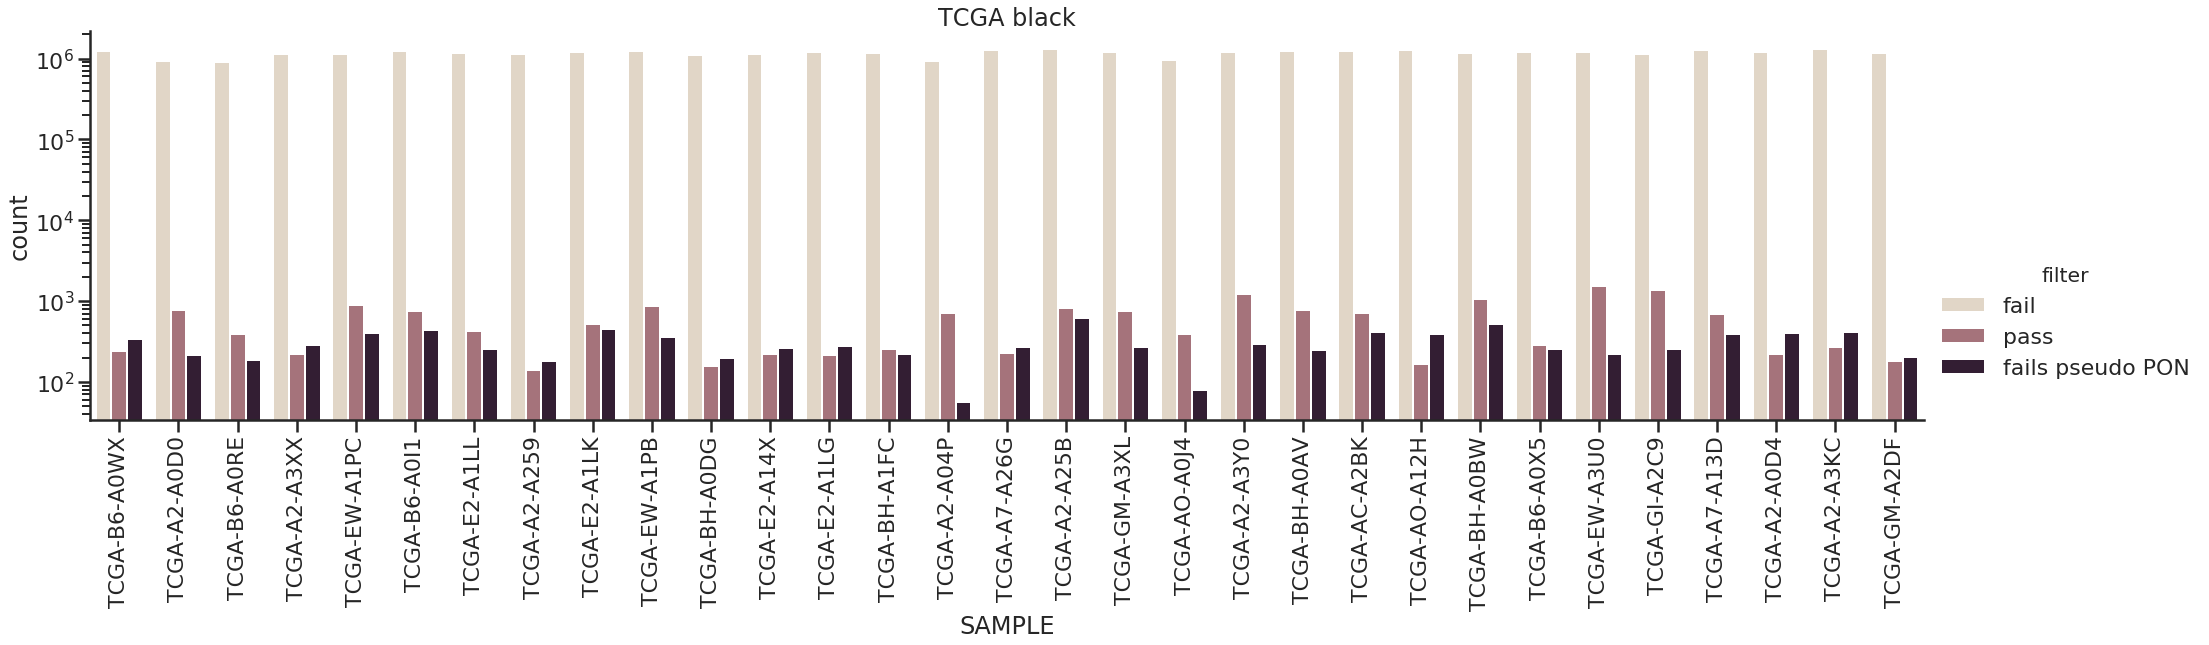

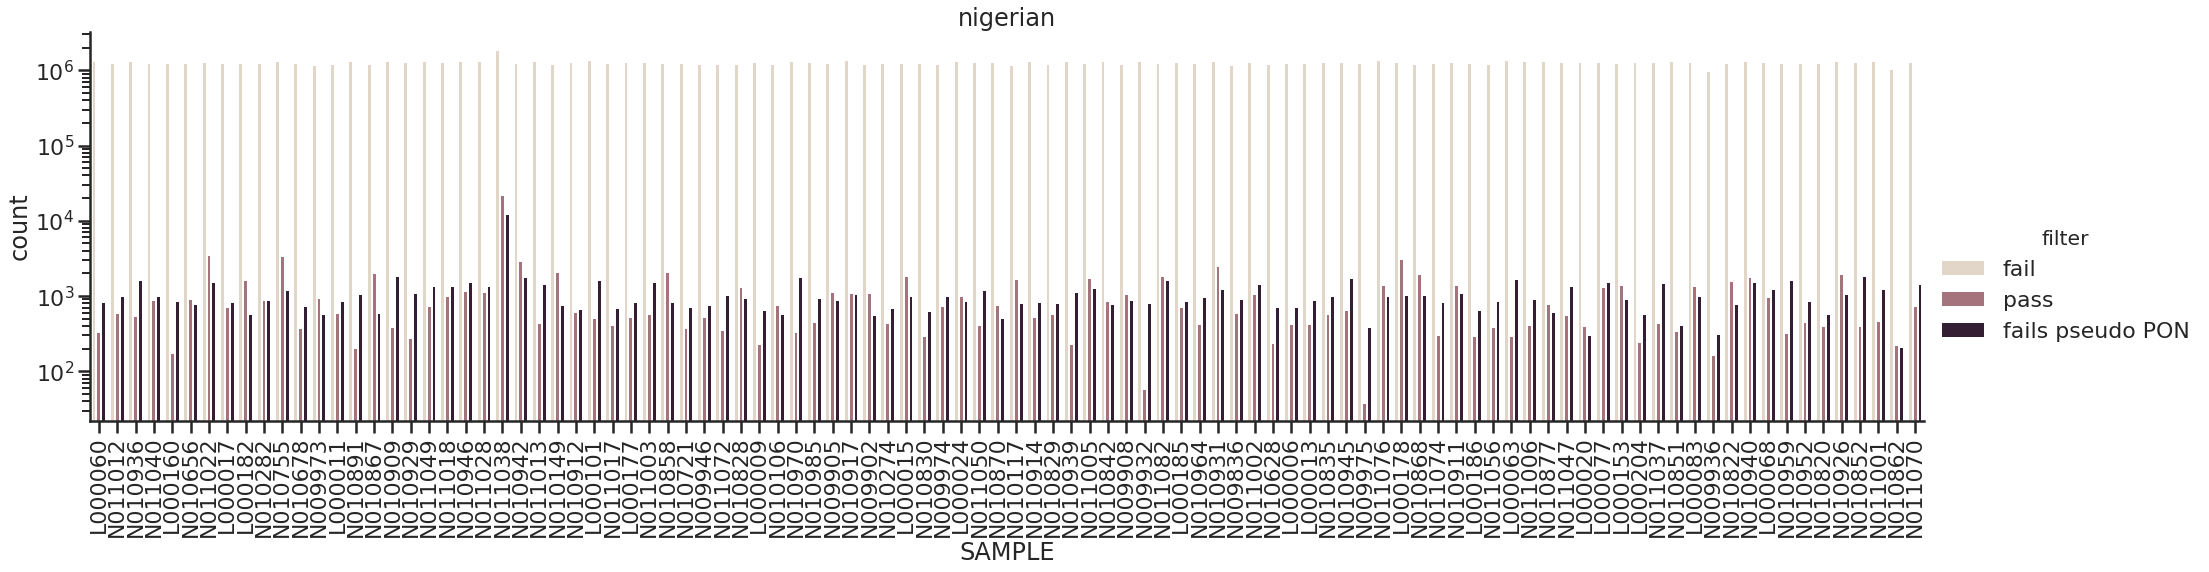

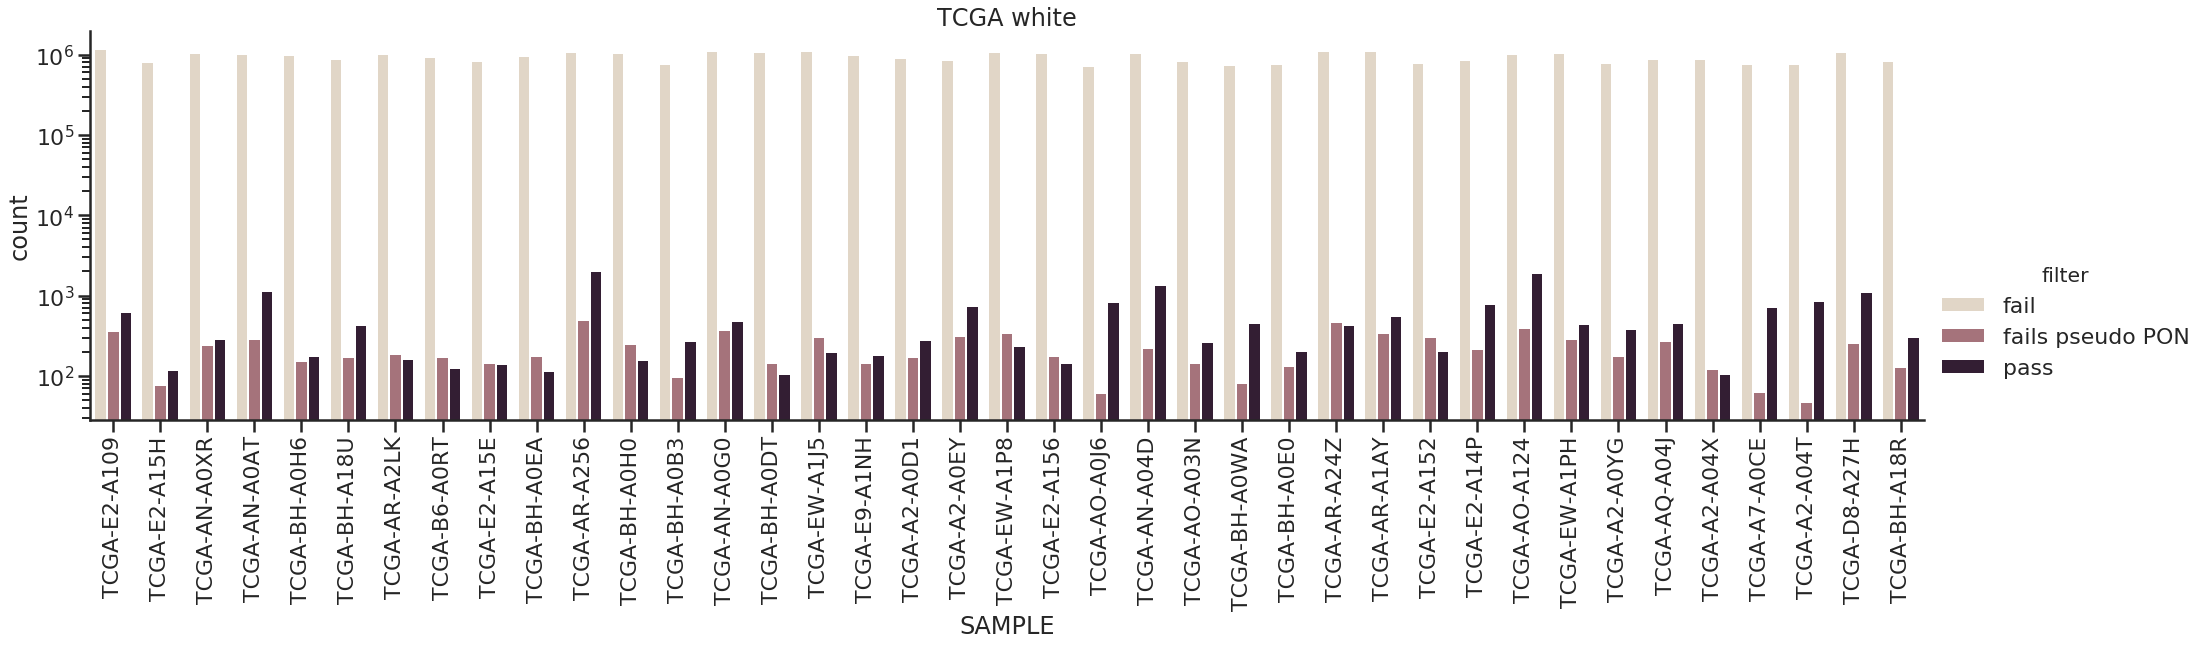

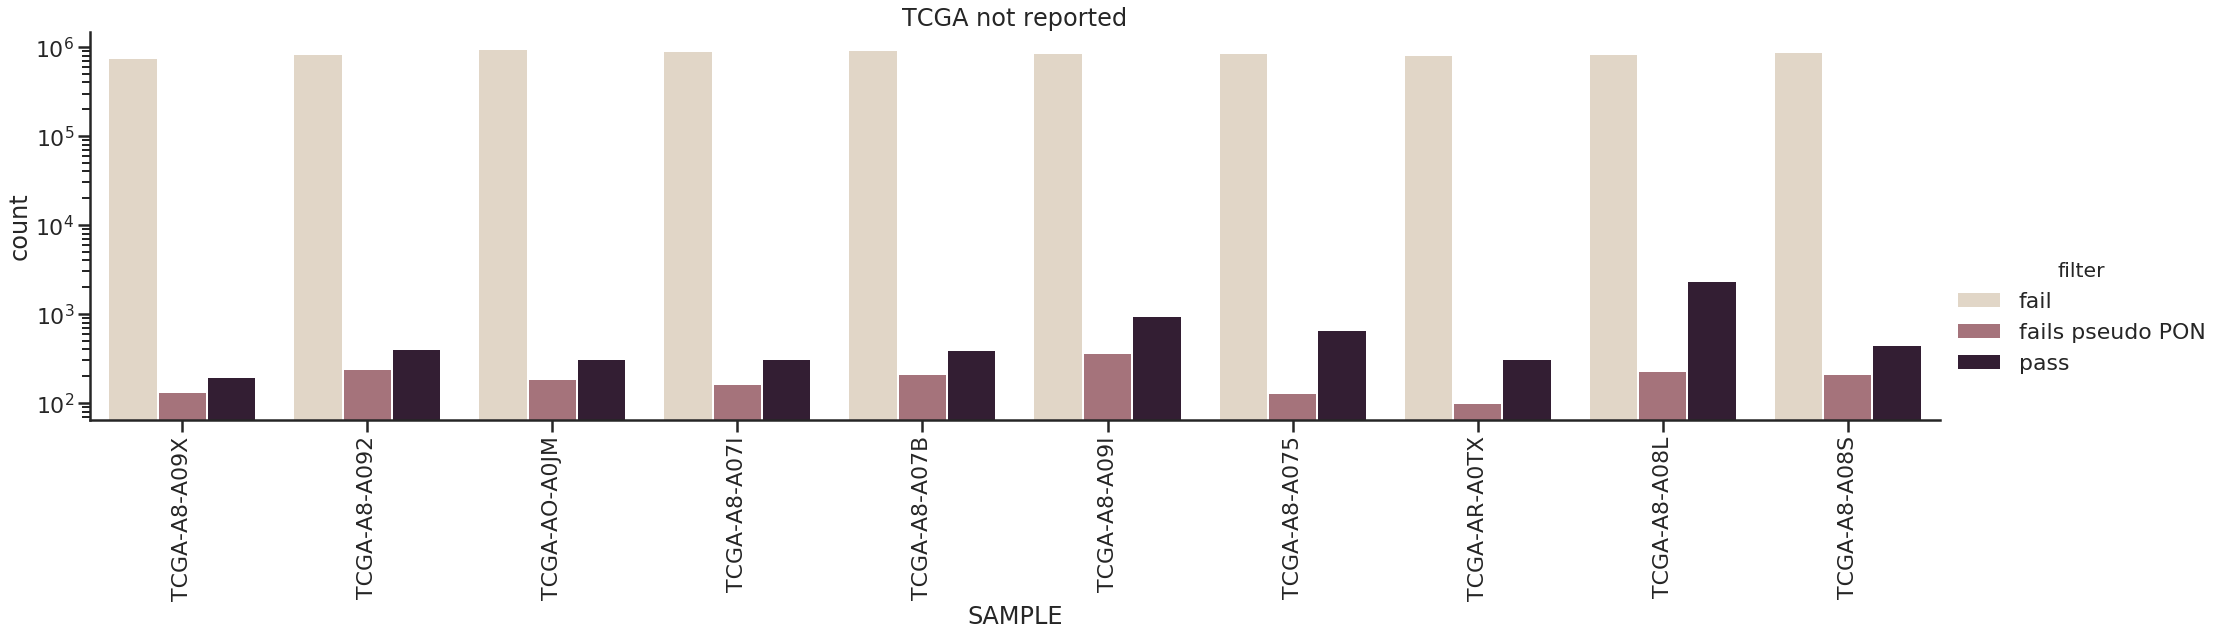

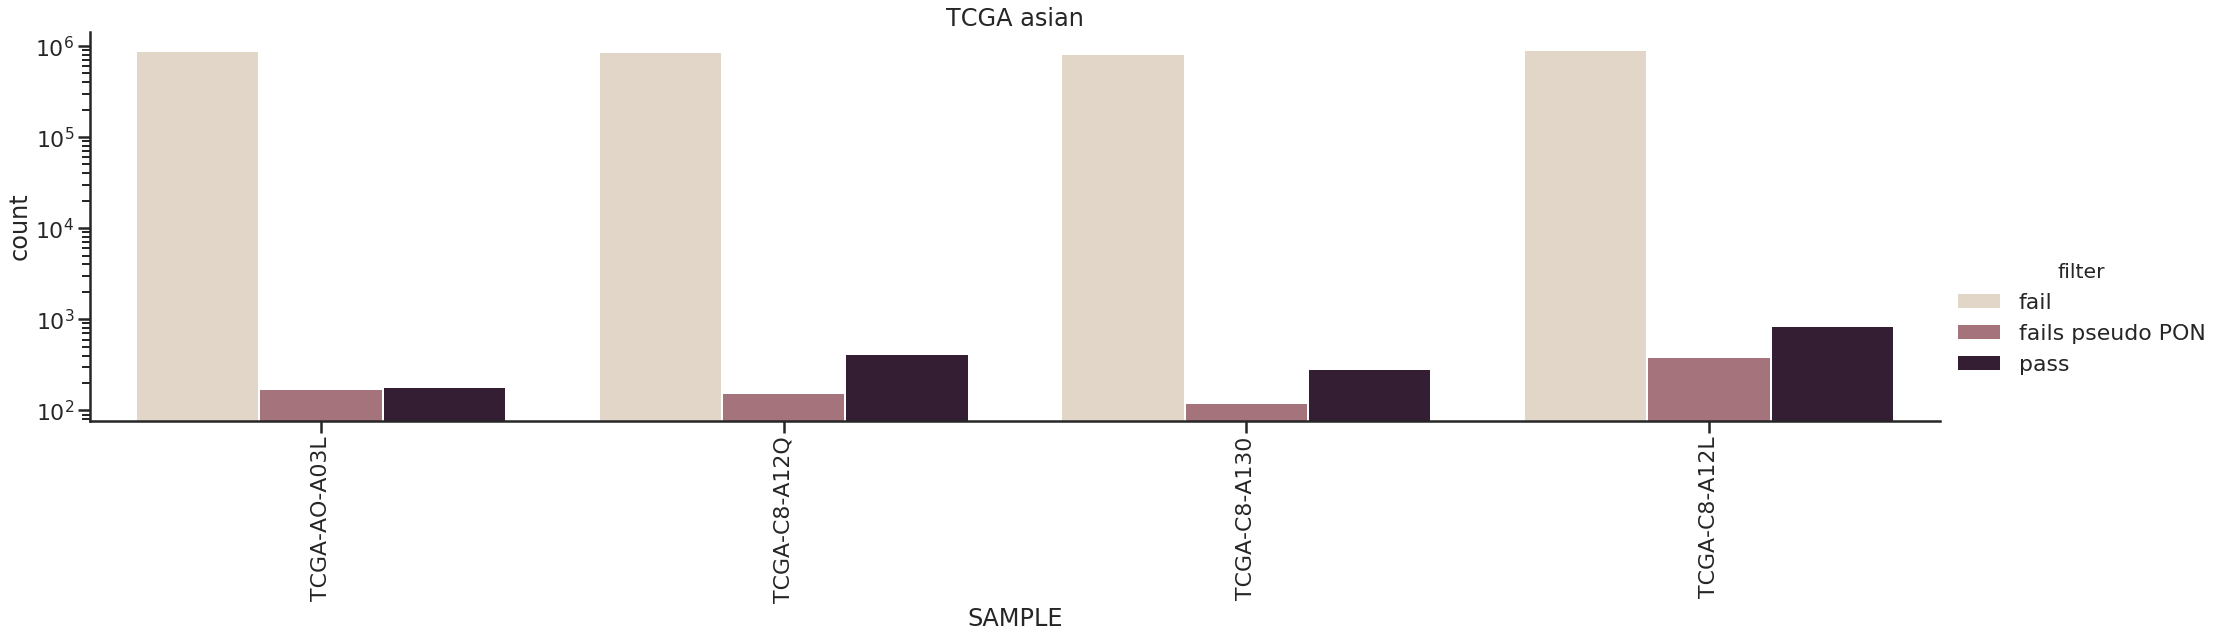

In [12]:
sns.set_context("poster", font_scale=1)
for race in full_df.RACE.unique():
    ax = sns.catplot(x="SAMPLE", hue="filter", kind="count", palette="ch:.25", data=full_df[df.RACE == race], height=7, aspect=4)
    ax.set_xticklabels(rotation=90)
    plt.yscale('log')
    plt.title(race)
    plt.savefig('plots/filter_counts_{}.pdf'.format(race.replace(' ', '_')), bbox_inches='tight')

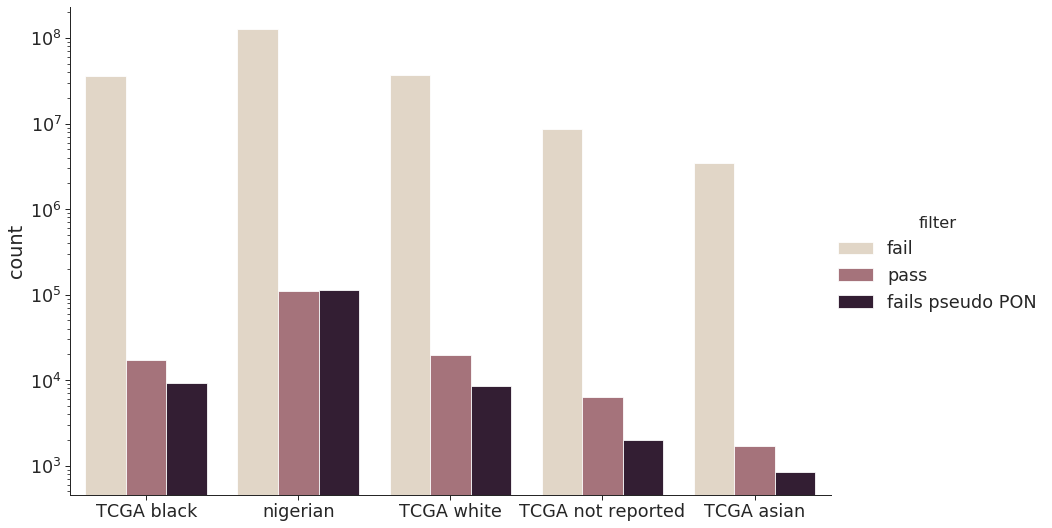

In [13]:
sns.set_context('paper', font_scale=2)
ax = sns.catplot(x="RACE", hue="filter", kind="count", palette="ch:.25", data=full_df, height=8.27, aspect=11.7/8.27)
plt.yscale('log')
plt.xlabel('')
plt.savefig('plots/pass_by_race.pdf', bbox_inches='tight')

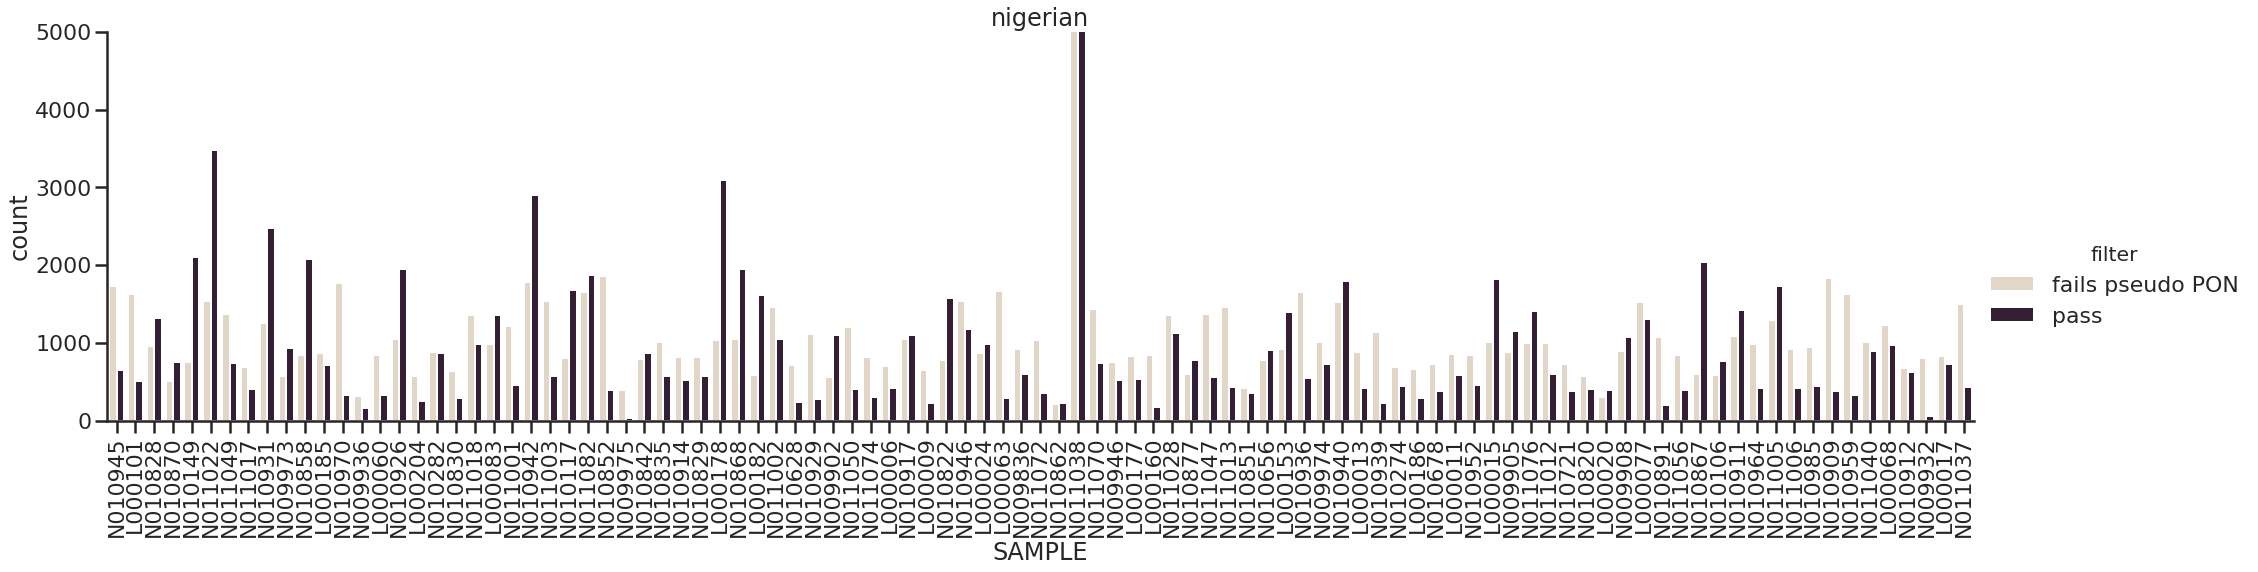

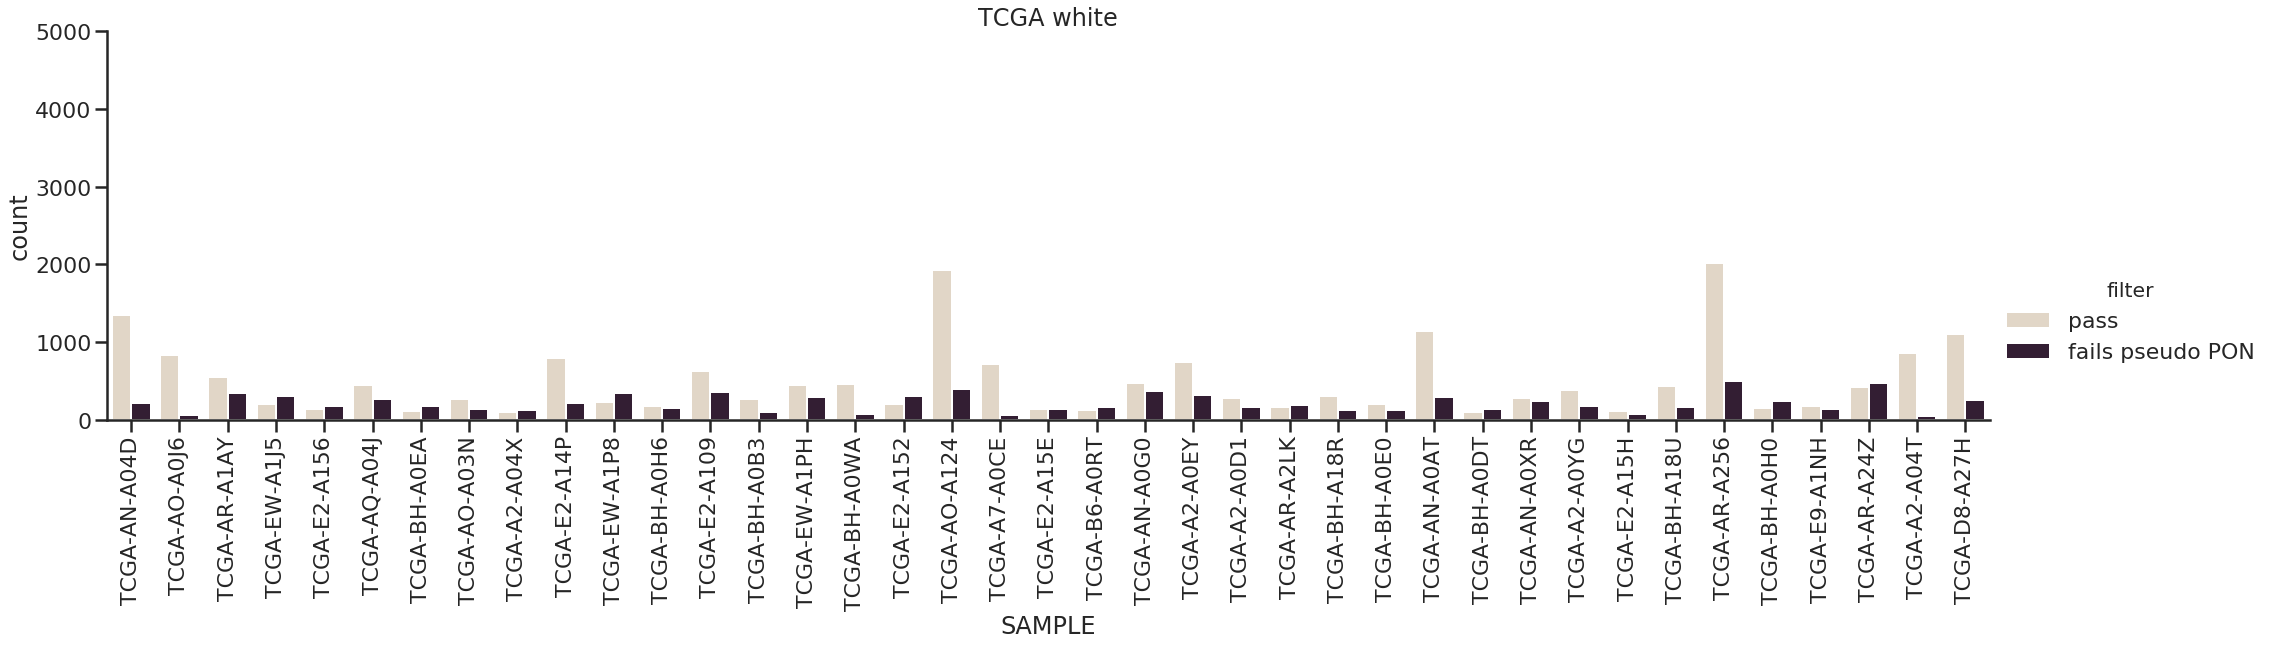

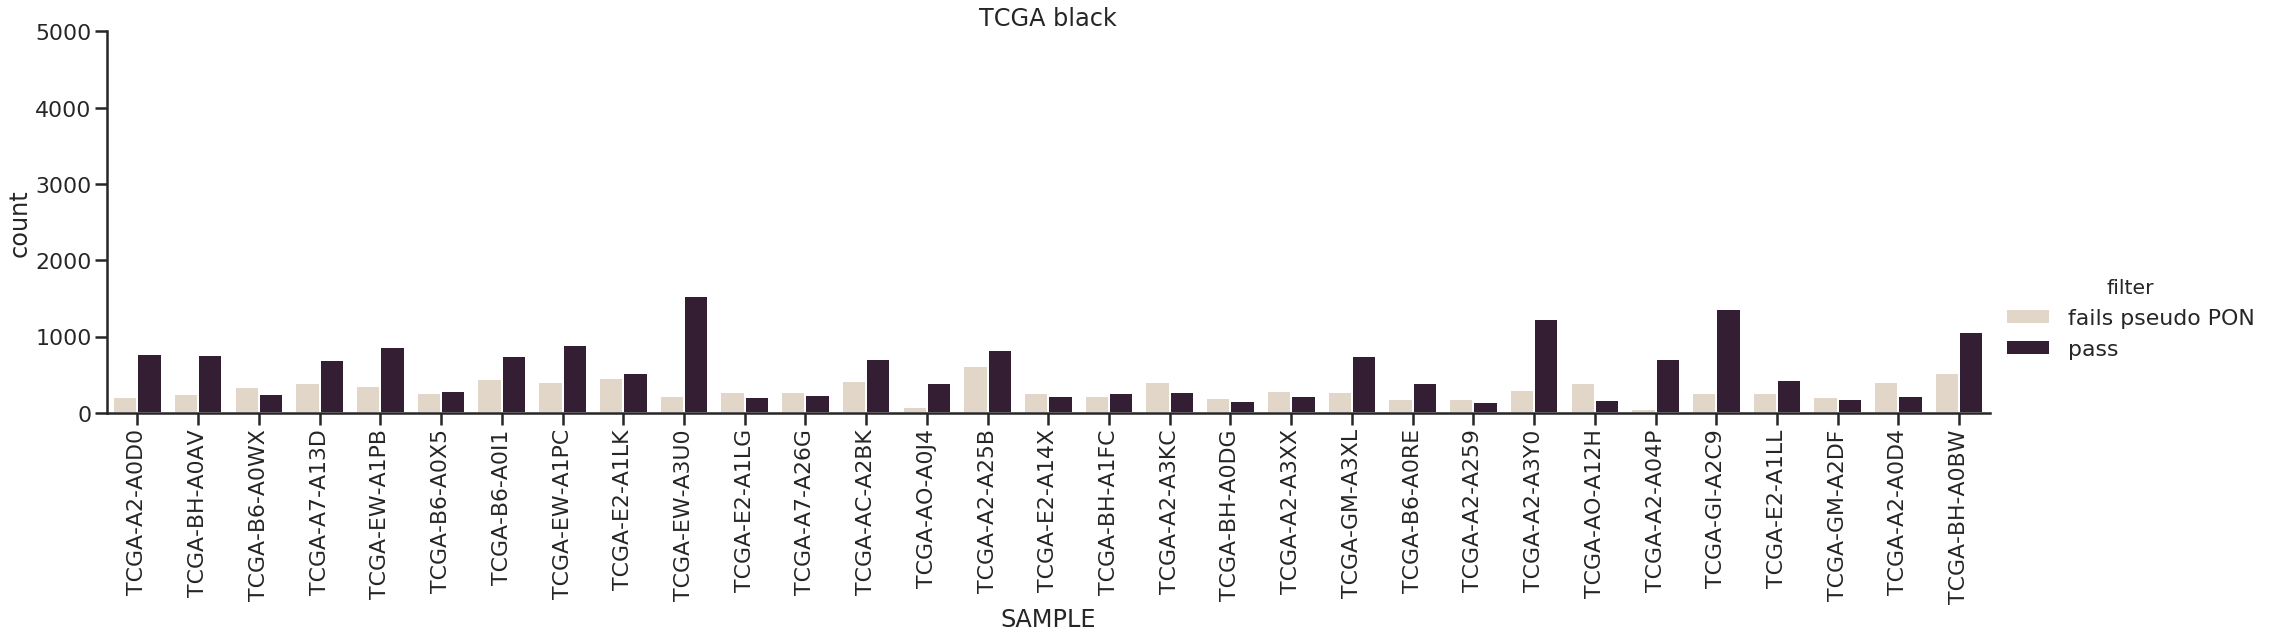

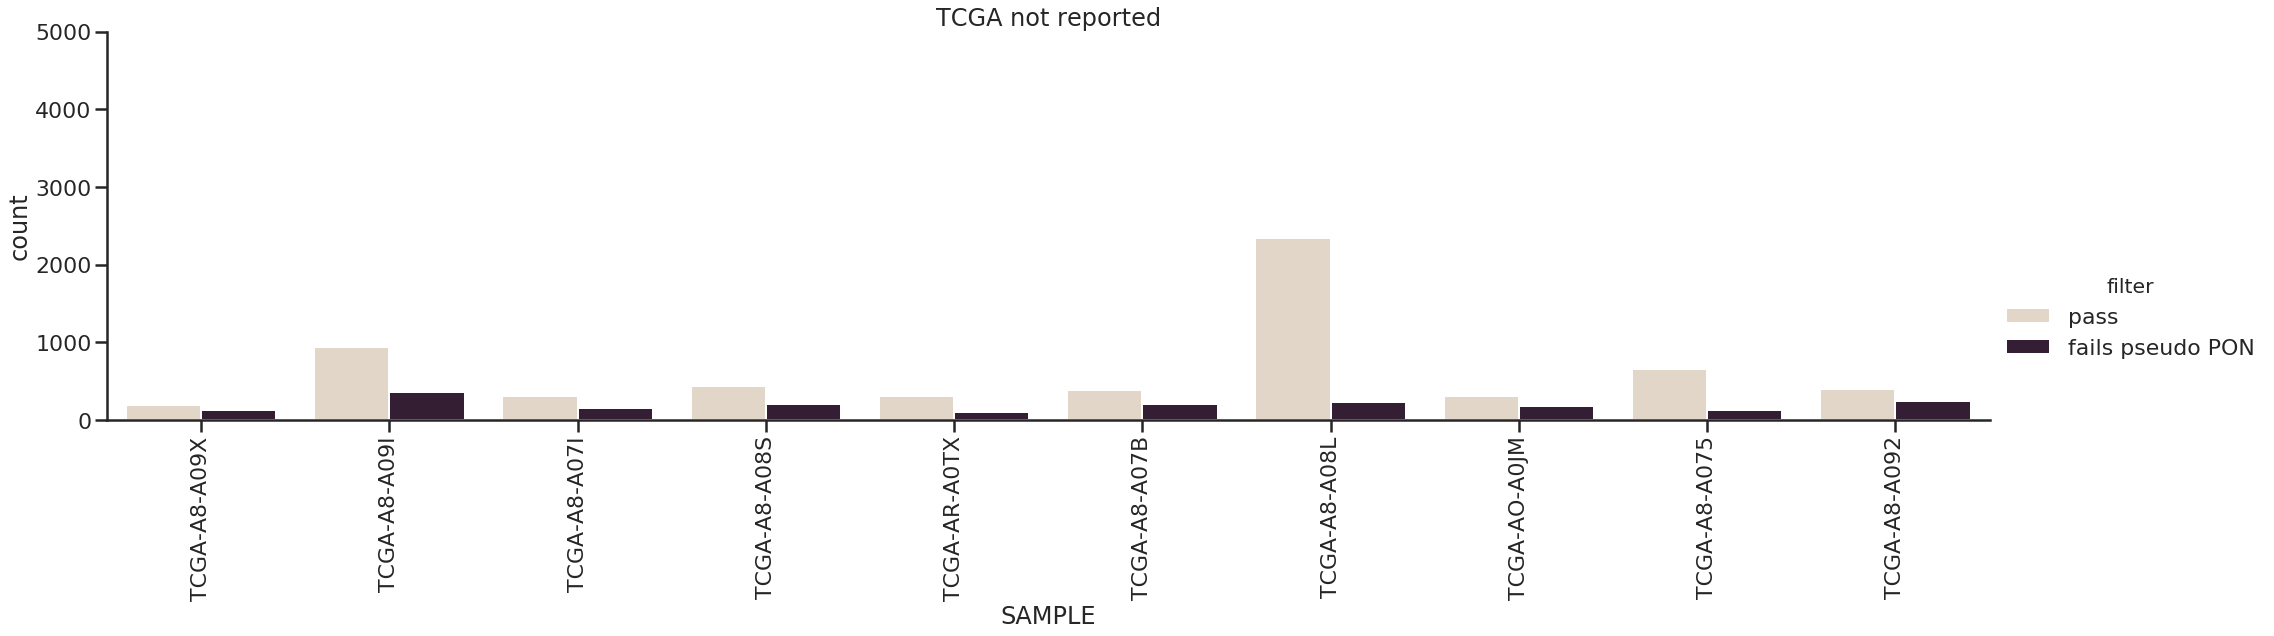

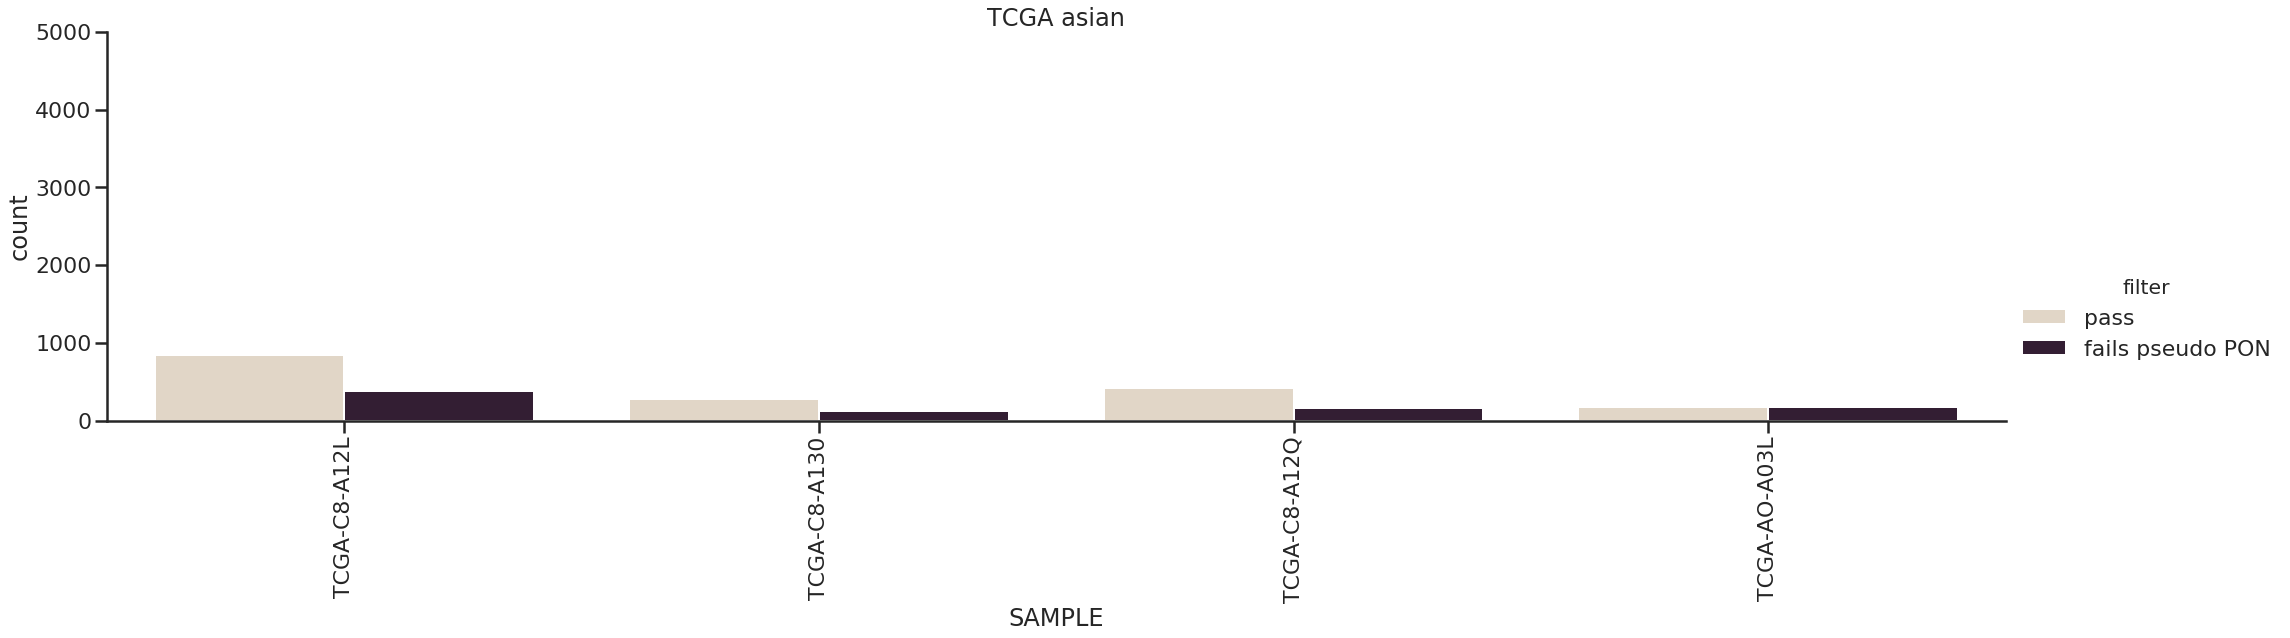

In [8]:
sns.set_context("poster", font_scale=1)
for race in slim_df.RACE.unique():
    ax = sns.catplot(x="SAMPLE", hue="filter", kind="count", palette="ch:.25", data=slim_df[slim_df.RACE == race], height=7, aspect=4)
    ax.set_xticklabels(rotation=90)
    plt.ylim(0, 5000)
    plt.title(race)
    plt.savefig('plots/filter_counts_{}_no_fail.pdf'.format(race.replace(' ', '_')), bbox_inches='tight')

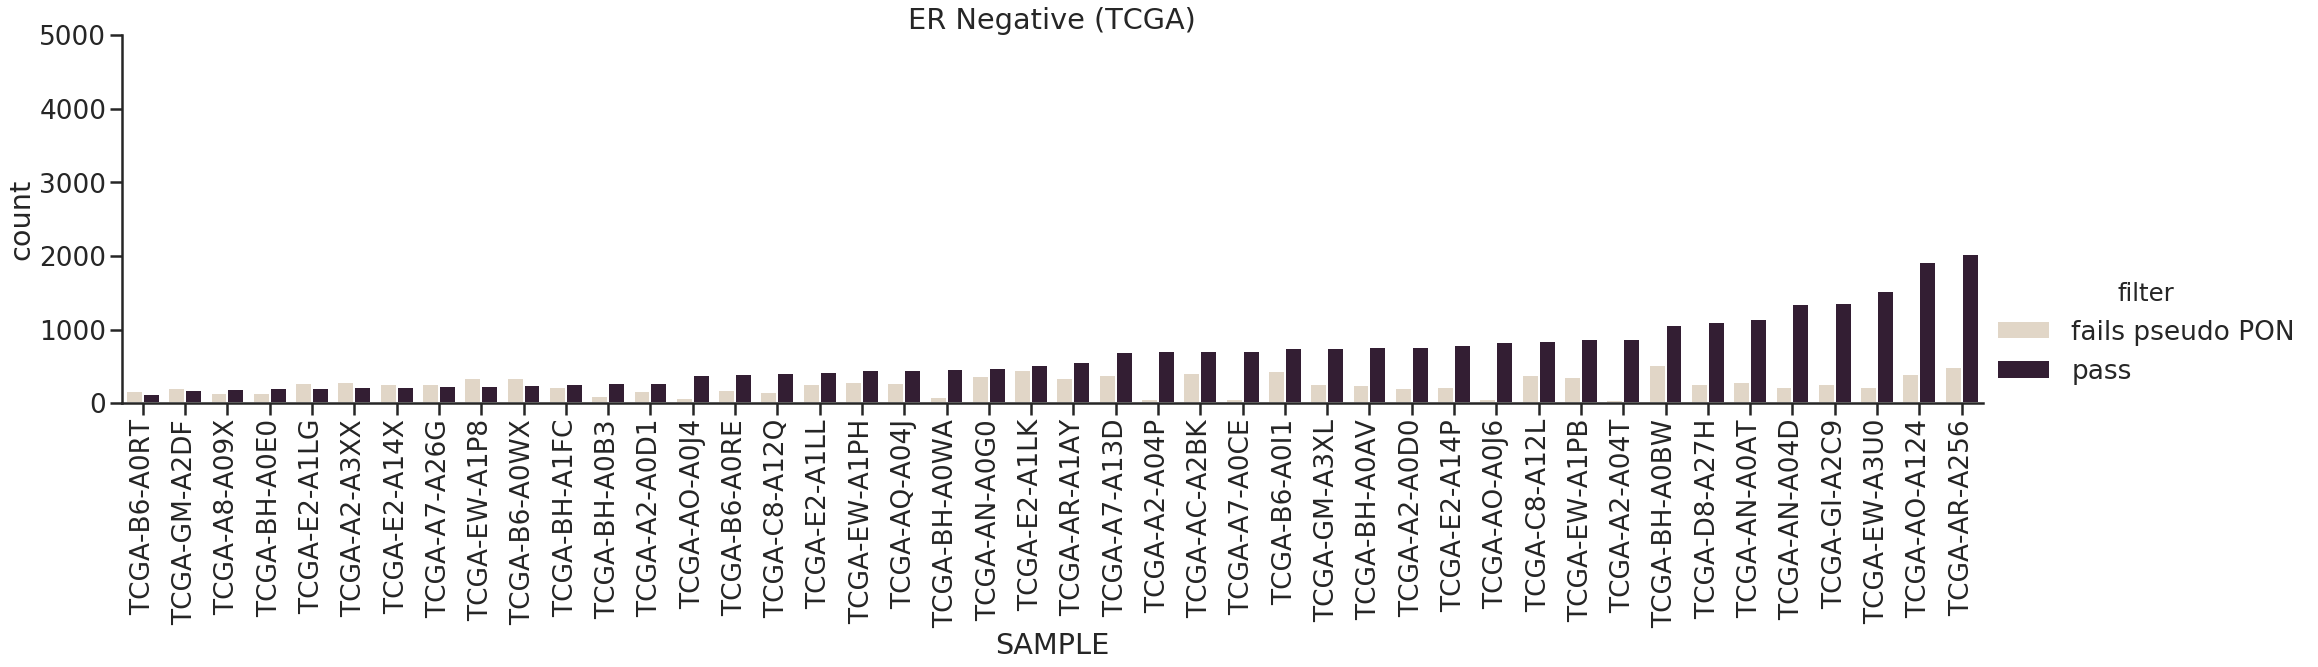

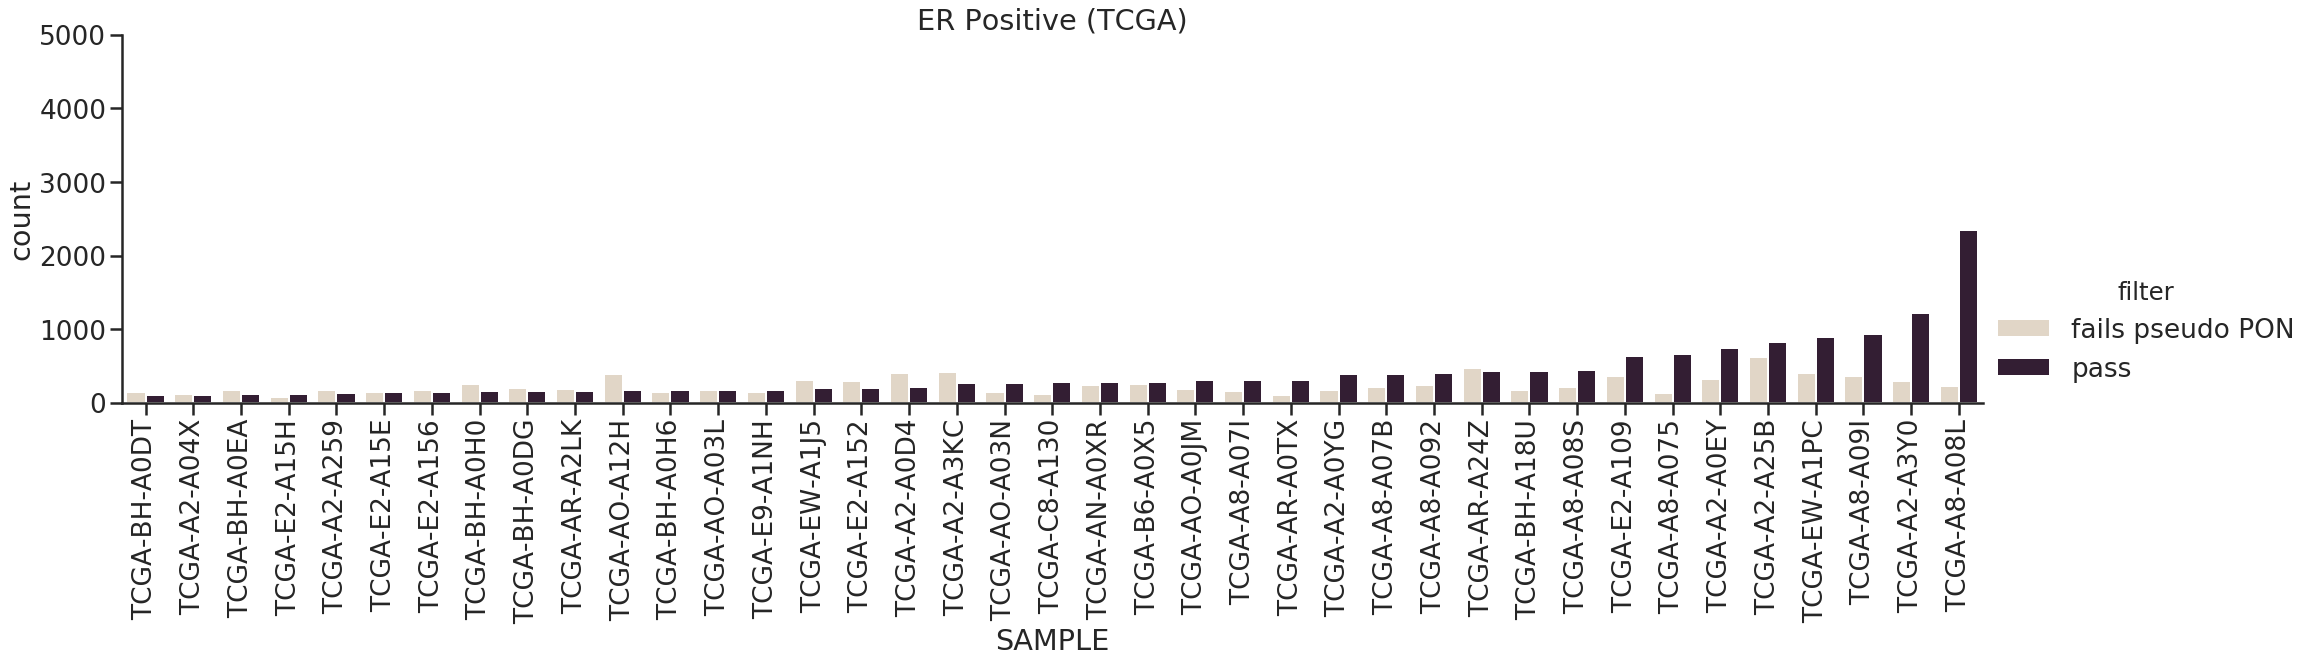

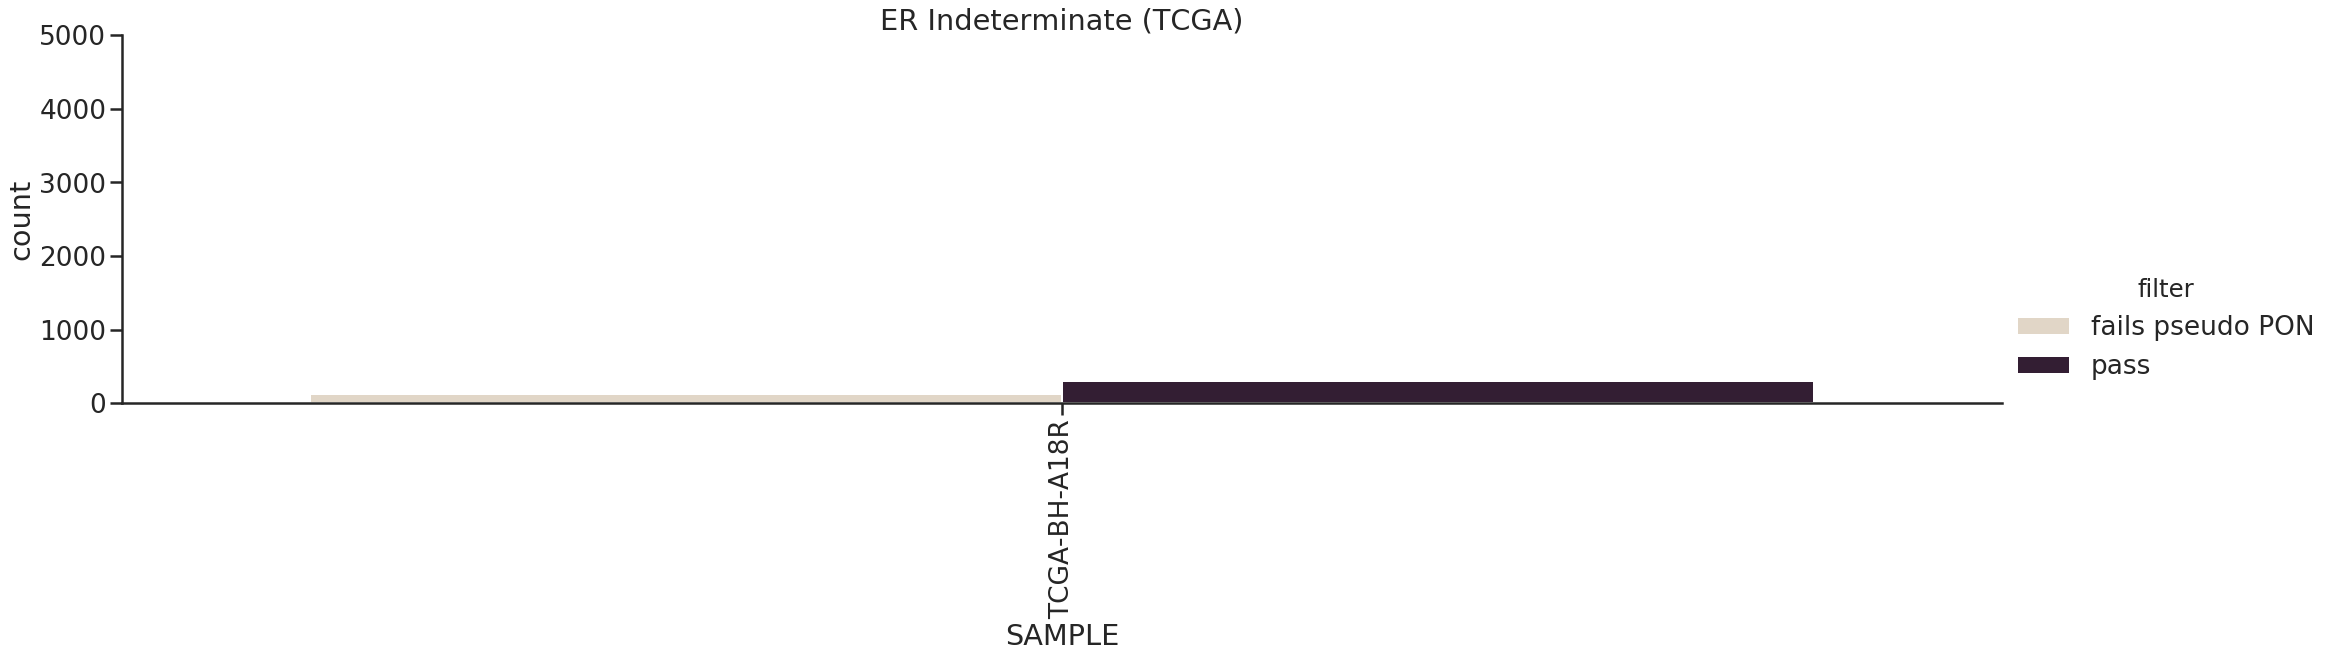

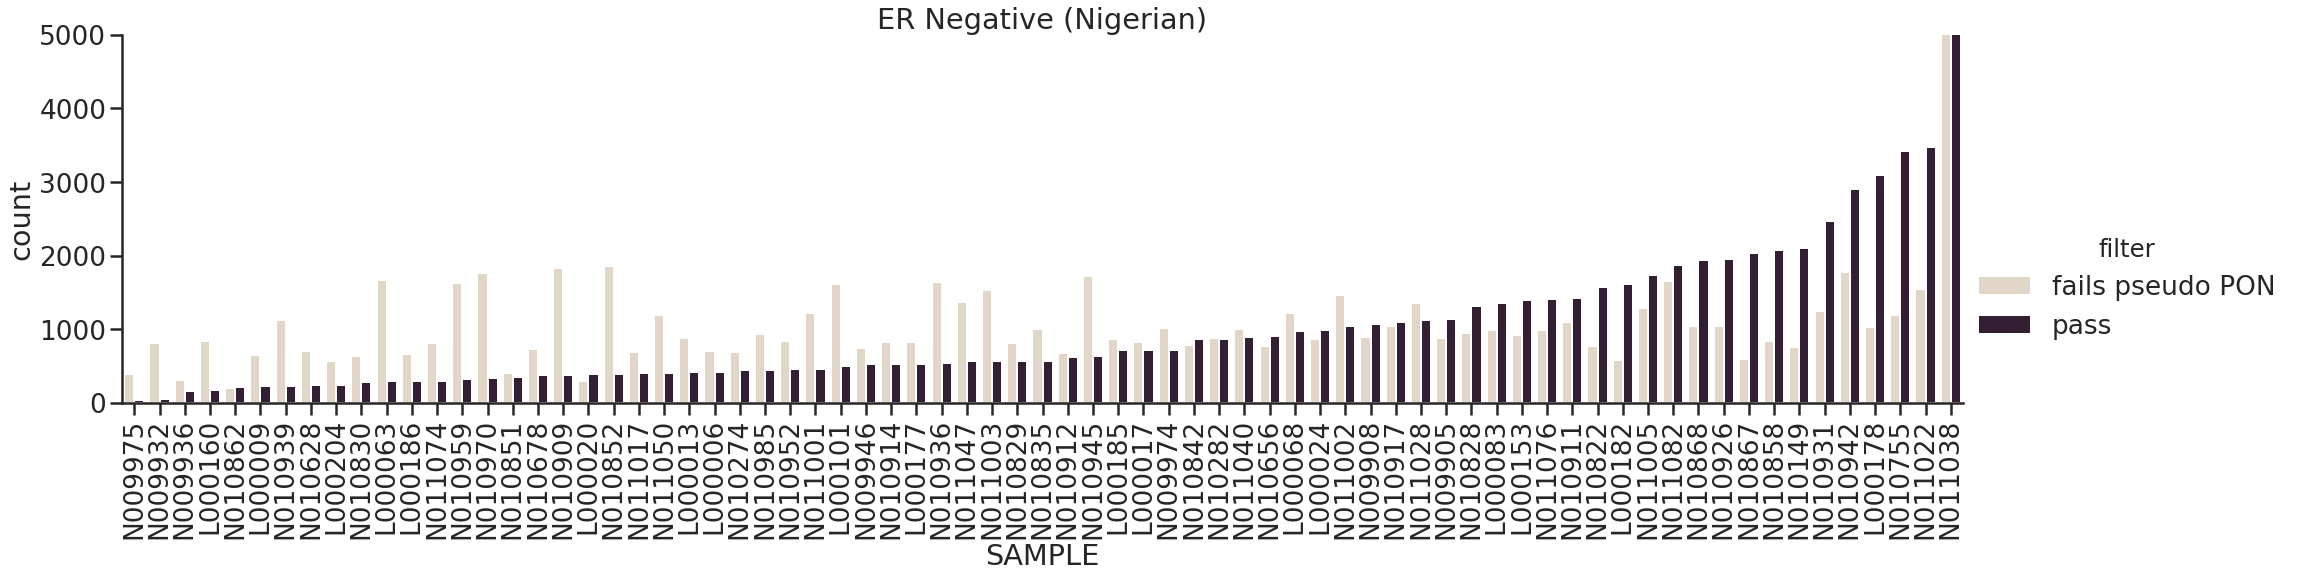

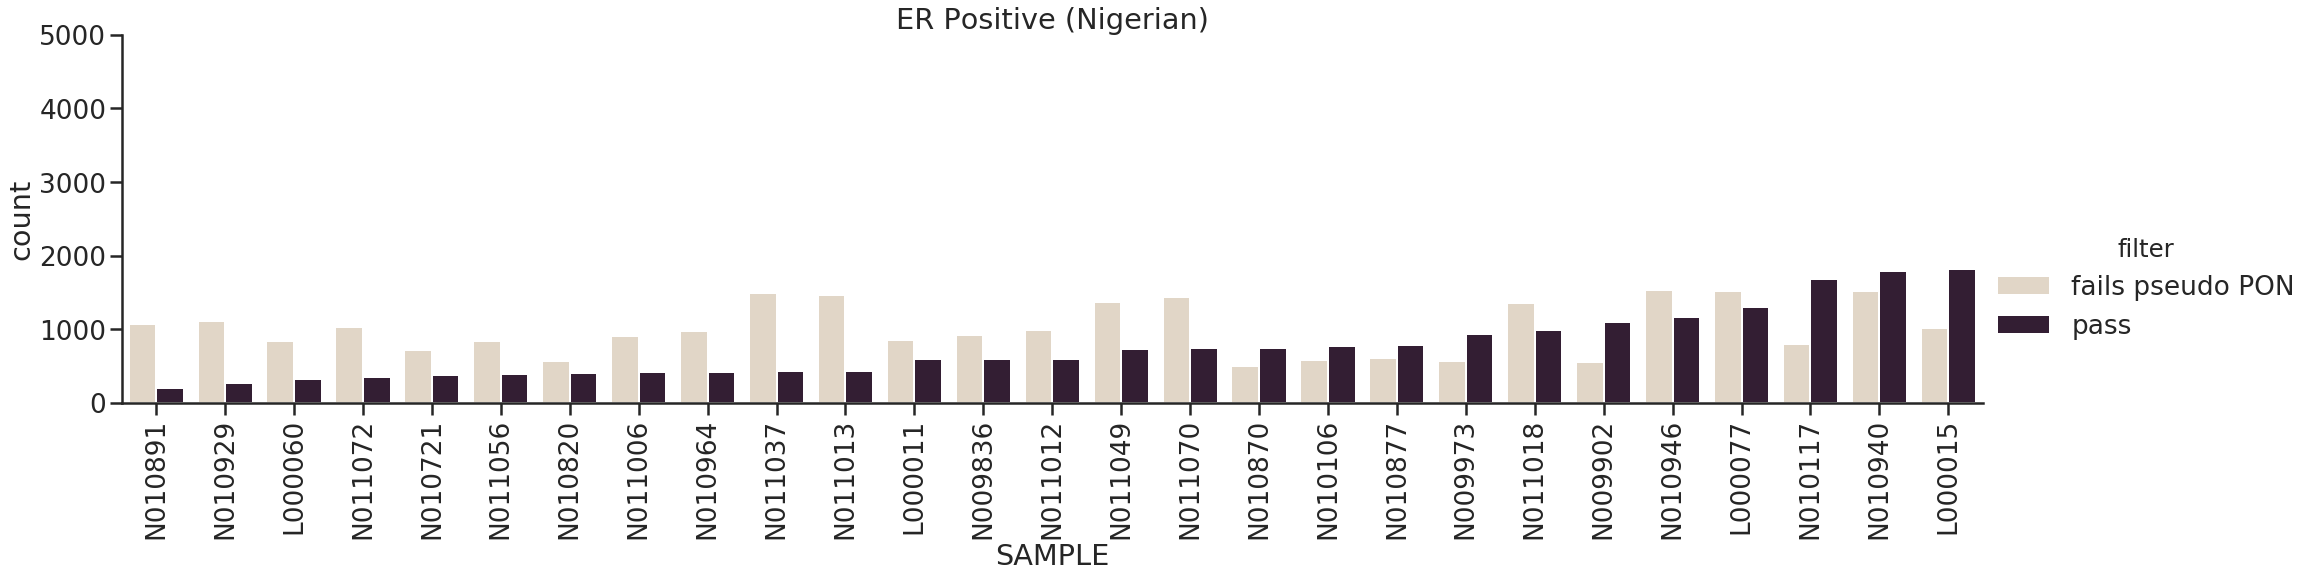

In [67]:
sns.set_context("poster", font_scale=1.2)

for race_cut, race_label in [(slim_df['RACE'].str.startswith('TCGA'), 'TCGA'), ((slim_df['RACE'] == 'nigerian'), 'Nigerian')]:
    for status in slim_df.loc[race_cut]['ER status'].unique():
        cut = race_cut & (slim_df['ER status'] == status)
        order = slim_df.loc[cut & (slim_df['filter'] == 'pass')]['SAMPLE'].value_counts().keys().to_list()
        ax = sns.catplot(x="SAMPLE", hue="filter", kind="count", palette="ch:.25", data=slim_df[race_cut], height=7, aspect=4, order=order[::-1])
        ax.set_xticklabels(rotation=90)
        plt.ylim(0, 5000)
        plt.title('ER {} ({})'.format(status, race_label))
        plt.savefig('plots/filter_counts_er_{}_{}_no_fail.pdf'.format(status, race_label), bbox_inches='tight')

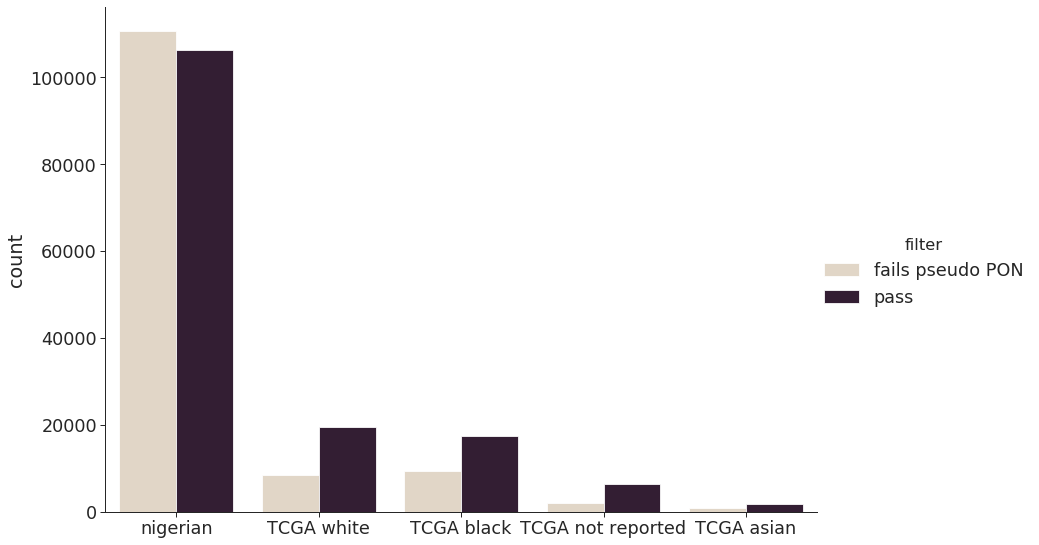

In [7]:
sns.set_context('paper', font_scale=2)
ax = sns.catplot(x="RACE", hue="filter", kind="count", palette="ch:.25", data=slim_df, height=8.27, aspect=11.7/8.27)
plt.xlabel('')
plt.savefig('plots/pass_by_race_no_fail.pdf', bbox_inches='tight')

In [6]:
races = full_df.RACE.unique()
fail_counts = [len(full_df.loc[(full_df['RACE'] == race) & (full_df['filter'] == 'fail')]) for race in races]
pass_counts = [len(slim_df.loc[(slim_df['RACE'] == race) & (slim_df['filter'] == 'pass')]) for race in races]
fail_pseudo_pon_counts = [len(slim_df.loc[(df['RACE'] == race) & (slim_df['filter'] == 'fails pseudo PON')]) for race in races]
summary = pd.DataFrame(data=
    {
        'race': races,
        'total fail': fail_counts,
        'total pass': pass_counts,
        'total fails pseudo PON': fail_pseudo_pon_counts,
        'pass / fails pseudo PON': ['{:.2f}'.format(numerator / float(denominator)) for numerator, denominator in zip(pass_counts, fail_pseudo_pon_counts)]
    }
)
summary

,race,fail,pass,fails pseudo PON,pass / fails pseudo PON
0,TCGA black,36253762,17454,9375,1.86
1,nigerian,127653642,109859,111932,0.98
2,TCGA white,36777097,19560,8521,2.30
3,TCGA not reported,8589978,6306,1978,3.19
4,TCGA asian,3470666,1717,837,2.05


In [3]:
slim_df

,CHROM,POS,REF,ALT,FILTER,SAMPLE,QUAL,RACE,ER status,PR status,HER2 status,filter,dbsnp,genomes1k
175,10,34233256,G,GA,pseudo PON,TCGA-B6-A0I1,300,TCGA black,Negative,Negative,[Not Evaluated],fails pseudo PON,fail,pass
199,9,32097274,GGAT,GCC,pseudo PON,N010936,720,nigerian,Negative,Negative,Positive,fails pseudo PON,pass,pass
635,14,38025353,T,TGGCGGCCGGGCAGA,pseudo PON,L000185,148,nigerian,Negative,Negative,Negative,fails pseudo PON,pass,pass
838,GL000205.1,39806,A,AT,pseudo PON,N009936,47,nigerian,Negative,Negative,Positive,fails pseudo PON,pass,pass
2161,2,43272704,ATATATATATATATATATATT,A,PASS,N010931,360,nigerian,Negative,Negative,Negative,pass,pass,pass
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213028622,13,96109518,T,TA,PASS,L000178,420,nigerian,Negative,Negative,Positive,pass,fail,pass
213030742,4,136593469,CATAATCTTCATCTAAGCCAGTTTTAGCTGGGGTTGTTACTGCGCA...,C,PASS,N010867,900,nigerian,Negative,Negative,Positive,pass,pass,pass
213031238,X,128552822,CAGCTAGTGAGAATCTGATAGCAAACCCTGAGTGCCTCTACTTTAG...,CCCAGGG,PASS,N010149,960,nigerian,Negative,Negative,Negative,pass,pass,pass
213031323,X,26335598,CTTGCTTTTCTAG,C,pseudo PON,N009905,72,nigerian,Negative,Negative,Negative,fails pseudo PON,pass,pass


In [38]:
cuts = [
    ((slim_df['RACE'] == 'TCGA black') & (slim_df['ER status'] == 'Positive'), 'Positive', 'TCGA black'),
    ((slim_df['RACE'] == 'TCGA black') & (slim_df['ER status'] == 'Negative'), 'Negative', 'TCGA black'),
    ((slim_df['RACE'] == 'TCGA black'), 'Inclusive', 'TCGA black'),
    ((slim_df['RACE'] == 'TCGA white') & (slim_df['ER status'] == 'Positive'), 'Positive', 'TCGA white'),
    ((slim_df['RACE'] == 'TCGA white') & (slim_df['ER status'] == 'Negative'), 'Negative', 'TCGA white'),
    ((slim_df['RACE'] == 'TCGA white'), 'Inclusive', 'TCGA white'),
    ((slim_df['RACE'] == 'nigerian') & (slim_df['ER status'] == 'Positive'), 'Positive', 'Nigerian'),
    ((slim_df['RACE'] == 'nigerian') & (slim_df['ER status'] == 'Negative'), 'Negative', 'Nigerian'),
    ((slim_df['RACE'] == 'nigerian'), 'Inclusive', 'Nigerian')
]

patient_counts = []
pass_means = []
fail_pseudo_pon_means = []
fail_dbsnp_means = []
fail_genome1k_means = []
final_pass_means = []

for cut, er_label, cohort_label in cuts:
    patients = slim_df.loc[cut, 'SAMPLE'].unique()
    patient_counts += [len(patients)]
    pass_counts = np.array([len(slim_df.loc[cut & (slim_df['filter'].isin(['pass', 'fails pseudo PON'])) & (slim_df['SAMPLE'] == patient)]) for patient in patients])
    pass_means += ['{:.0f} ({:.0f})'.format(pass_counts.mean(), np.std(pass_counts))]
    fail_pseudo_pon_counts = np.array([len(slim_df.loc[cut & (slim_df['filter'] == 'fails pseudo PON') & (slim_df['SAMPLE'] == patient)]) for patient in patients])
    fail_pseudo_pon_means += ['{:.0f} ({:.0f})'.format(fail_pseudo_pon_counts.mean(), np.std(fail_pseudo_pon_counts))]
    fail_dbsnp_counts = np.array([len(slim_df.loc[cut & (slim_df['dbsnp'] == 'fail') & (slim_df['SAMPLE'] == patient)]) for patient in patients])
    fail_dbsnp_means += ['{:.0f} ({:.0f})'.format(fail_dbsnp_counts.mean(), np.std(fail_dbsnp_counts))]
    fail_genome1k_counts = np.array([len(slim_df.loc[cut & (slim_df['genomes1k'] == 'fail') & (slim_df['SAMPLE'] == patient)]) for patient in patients])
    fail_genome1k_means += ['{:.0f} ({:.0f})'.format(fail_genome1k_counts.mean(), np.std(fail_genome1k_counts))]
    final_pass_counts = np.array([len(slim_df.loc[cut & (slim_df['filter'] == 'pass') & (slim_df['dbsnp'] == 'pass') & (slim_df['genomes1k'] == 'pass') & (slim_df['SAMPLE'] == patient)]) for patient in patients])
    final_pass_means += ['{:.0f} ({:.0f})'.format(final_pass_counts.mean(), np.std(final_pass_counts))]
    
summary = pd.DataFrame(data=
    {
        'race': [cohort_label for cut, er_label, cohort_label in cuts],
        'ER status': [er_label for cut, er_label, cohort_label in cuts],
        'number of patients': patient_counts,
        'mean (original pass)': pass_means,
        'mean (fails pseudo-PON)': fail_pseudo_pon_means,
        'mean (fails dbsnp)': fail_dbsnp_means,
        'mean (fails 1k genomes)': fail_genome1k_means,
        'mean (passes pseudo-PON, dbsnp, 1k genomes)': final_pass_means
    }
)
summary

,race,ER status,number of patients,mean (original pass),mean (fails pseudo-PON),mean (fails dbsnp),mean (fails 1k genomes),"mean (passes pseudo-PON, dbsnp, 1k genomes)"
0,TCGA black,Positive,9,814 (442),350 (128),291 (138),24 (11),373 (345)
1,TCGA black,Negative,22,887 (403),283 (112),241 (126),21 (10),515 (359)
2,TCGA black,Inclusive,31,865 (416),302 (121),256 (131),22 (11),474 (361)
3,TCGA white,Positive,19,477 (248),214 (95),203 (110),15 (9),198 (130)
4,TCGA white,Negative,19,978 (604),228 (125),242 (148),20 (13),654 (507)
5,TCGA white,Inclusive,39,720 (520),218 (111),220 (131),18 (11),421 (430)
6,Nigerian,Positive,27,1765 (613),1009 (340),705 (309),40 (23),556 (346)
7,Nigerian,Negative,73,2385 (3906),1160 (1386),978 (2490),60 (188),881 (1278)
8,Nigerian,Inclusive,100,2218 (3364),1119 (1200),904 (2137),55 (161),793 (1116)


In [33]:
dbsnp = [tuple(x) for x in slim_df.loc[slim_df['dbsnp'] == 'fail', ['CHROM', 'POS', 'REF', 'ALT']].values.tolist()]
genomes1k = [tuple(x) for x in slim_df.loc[slim_df['genomes1k'] == 'fail', ['CHROM', 'POS', 'REF', 'ALT']].values.tolist()]
ppon = [tuple(x) for x in slim_df.loc[slim_df['filter'] == 'fails pseudo PON', ['CHROM', 'POS', 'REF', 'ALT']].values.tolist()]

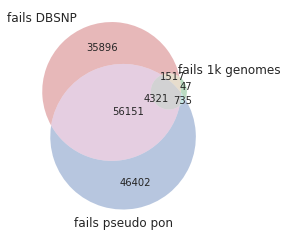

In [36]:
venn3([set(dbsnp), set(genomes1k), set(ppon)], set_labels = ('fails DBSNP', 'fails 1k genomes', 'fails pseudo pon'))
plt.savefig('plots/fail_DBSNP_ppon_1kgenomes_venn.pdf', bbox_inches='tight')

In [13]:
columns = ['CHROM', 'POS', 'REF', 'ALT']

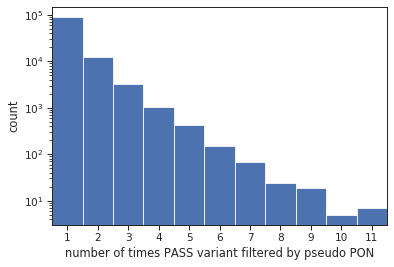

In [8]:
filtered_counts = slim_df.loc[slim_df['filter'] == 'fails pseudo PON'].groupby(columns).size().reset_index(name='counts')['counts']

sns.set_context('paper', font_scale=1.2)
ax = filtered_counts.hist(bins=range(filtered_counts.max()))
ax.set_xticks(np.arange(filtered_counts.max()) + .5)
ax.set_xticklabels(range(filtered_counts.max()))
ax.grid(False)
plt.yscale('log')
plt.xlim(1, filtered_counts.max() - 1)
plt.xlabel('number of times PASS variant filtered by pseudo PON')
plt.ylabel('count')
plt.savefig('plots/pseudo_pon_filtering_frequency.pdf', bbox_inches='tight')

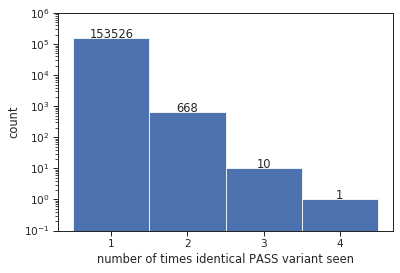

In [10]:
pass_counts = slim_df.loc[slim_df['FILTER'] == 'PASS'].groupby(columns).size().reset_index(name='counts')['counts']

bin_values, bin_edges = np.histogram(pass_counts, bins=np.arange(pass_counts.max() + 0.5) + 0.5)

ax = pass_counts.hist(bins=bin_edges)
ax.set_xticks(np.arange(pass_counts.max()) + 1)
ax.set_xticklabels([i + 1 for i in range(pass_counts.max())])
plt.grid(False)
plt.yscale('log')
plt.ylim(ymin=0.1, ymax=1e6)
plt.xlabel('number of times identical PASS variant seen')
plt.ylabel('count')

for i in range(len(bin_values)):
    plt.text(bin_edges[i] + 0.5, bin_values[i], str(bin_values[i]), ha='center')
    
plt.savefig('plots/pass_frequency.pdf', bbox_inches='tight')

In [13]:
len(df.loc[(df['RACE'] == 'TCGA white') & (df['filter'] == 'pass')]) / len(df[df['RACE'] == 'TCGA white']['SAMPLE'].unique())

501.53846153846155

In [15]:
len(df.loc[(df['RACE'] == 'TCGA white') & (df['filter'].isin(['pass', 'fails pseudo PON']))]) / len(df[df['RACE'] == 'TCGA white']['SAMPLE'].unique())

720.025641025641

In [9]:
dbsnp

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO
0,1,10177,rs367896724,A,AC,.,.,RS=367896724;RSPOS=10177;dbSNPBuildID=138;SSR=...
1,1,10352,rs555500075,T,TA,.,.,RS=555500075;RSPOS=10352;dbSNPBuildID=142;SSR=...
2,1,10616,rs376342519,CCGCCGTTGCAAAGGCGCGCCG,C,.,.,RS=376342519;RSPOS=10617;dbSNPBuildID=142;SSR=...
3,1,11012,rs544419019,C,G,.,.,RS=544419019;RSPOS=11012;dbSNPBuildID=142;SSR=...
4,1,11063,rs561109771,T,G,.,.,RS=561109771;RSPOS=11063;dbSNPBuildID=142;SSR=...
...,...,...,...,...,...,...,...,...
37906826,Y,28769387,rs79521569,T,"C,G",.,.,RS=79521569;RSPOS=28769387;dbSNPBuildID=131;SS...
37906827,Y,28770633,rs771929773,T,TA,.,.,RS=771929773;RSPOS=28770633;dbSNPBuildID=144;S...
37906828,Y,28770651,rs775532266,G,A,.,.,RS=775532266;RSPOS=28770651;dbSNPBuildID=144;S...
37906829,Y,28770656,rs746807977,A,G,.,.,RS=746807977;RSPOS=28770656;dbSNPBuildID=144;S...


In [5]:
slim_df['dbsnp'] = 'pass'

In [9]:
slim_df

,CHROM,POS,REF,ALT,FILTER,SAMPLE,QUAL,RACE,ER status,PR status,HER2 status,filter
175,10,34233256,G,GA,pseudo PON,TCGA-B6-A0I1,300,TCGA black,Negative,Negative,[Not Evaluated],fails pseudo PON
199,9,32097274,GGAT,GCC,pseudo PON,N010936,720,nigerian,Negative,Negative,Positive,fails pseudo PON
635,14,38025353,T,TGGCGGCCGGGCAGA,pseudo PON,L000185,148,nigerian,Negative,Negative,Negative,fails pseudo PON
838,GL000205.1,39806,A,AT,pseudo PON,N009936,47,nigerian,Negative,Negative,Positive,fails pseudo PON
2161,2,43272704,ATATATATATATATATATATT,A,PASS,N010931,360,nigerian,Negative,Negative,Negative,pass
...,...,...,...,...,...,...,...,...,...,...,...,...
213028622,13,96109518,T,TA,PASS,L000178,420,nigerian,Negative,Negative,Positive,pass
213030742,4,136593469,CATAATCTTCATCTAAGCCAGTTTTAGCTGGGGTTGTTACTGCGCA...,C,PASS,N010867,900,nigerian,Negative,Negative,Positive,pass
213031238,X,128552822,CAGCTAGTGAGAATCTGATAGCAAACCCTGAGTGCCTCTACTTTAG...,CCCAGGG,PASS,N010149,960,nigerian,Negative,Negative,Negative,pass
213031323,X,26335598,CTTGCTTTTCTAG,C,pseudo PON,N009905,72,nigerian,Negative,Negative,Negative,fails pseudo PON


In [7]:
371993/560

664.2732142857143

In [9]:
slim_df.loc[slim_df['RACE'] == 'nigerian', 'SAMPLE'].unique()

array(['N010936', 'L000185', 'N009936', 'N010931', 'N010678', 'N010149',
       'N011038', 'L000013', 'L000182', 'N009946', 'N011022', 'N010822',
       'N011082', 'L000083', 'N010911', 'N011076', 'N009905', 'N009975',
       'N010858', 'N009902', 'N010868', 'N011037', 'N011047', 'N011005',
       'L000178', 'N011028', 'N010755', 'N009974', 'N010914', 'N011012',
       'N010940', 'N010820', 'N010942', 'N011018', 'N011001', 'L000068',
       'L000006', 'N010946', 'N010917', 'N010628', 'N010970', 'L000160',
       'N010842', 'N010964', 'N011049', 'N010939', 'N010656', 'N010926',
       'L000186', 'N011017', 'L000011', 'N010828', 'N010945', 'N010830',
       'N011056', 'N010106', 'N011050', 'N010870', 'L000077', 'N010721',
       'N010985', 'N011002', 'N011070', 'L000015', 'L000153', 'N010852',
       'N009908', 'N010912', 'L000020', 'L000063', 'N010959', 'N009836',
       'N011072', 'N011006', 'L000204', 'L000060', 'N010835', 'N010929',
       'N011003', 'N010867', 'N010829', 'N010117', 